### Analyze Sensitivity Results

In [3]:
import pandas as pd
tgt_dirs = [1]
base_res_dir = 'nb_hydr_static_v5_sssim_cali_exp_3'
cali_dir = 'cali_exp_3'
calibration_data = pd.read_csv('2020P2_calibration_data_30m.csv')[0:200]

In [4]:
import os
import pandas as pd
results = []
for i in tgt_dirs:
    res_dir = '{}_{}'.format(base_res_dir, i)
    contents = os.listdir(res_dir)
    result_name = 'chw_sup_m.m_flow'
    outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
    result_idx = outputs.index(result_name)
    for content in contents:
        if 'run' in content:
            result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
            result_pd = pd.read_csv(result_file_path, header = None)
            results.append(result_pd.values[:, result_idx])
print(len(results))

88


In [ ]:
import shutil
# clear temp results
for content in os.listdir(res_dir):
    if 'run' in content:
        sub_contents = os.listdir(res_dir + os.sep + content)
        for sub_content in sub_contents:
            if 'simres_run' in sub_content:
                shutil.rmtree(res_dir + os.sep + content + os.sep + sub_content)

In [5]:
# remove results with none
import numpy as np
val_idx = []
for i in range(len(results)):
    result_i = results[i]
    if np.isnan(result_i).sum() == 0:
        val_idx.append(i)
results_clean = [results[j] for j in val_idx]


val_idx_col = []
for i in range(np.array(results).shape[1]):
    result_i = np.array(results)[:, i]
    if np.isnan(result_i).sum() == 0:
        val_idx_col.append(i)
len(val_idx)

88

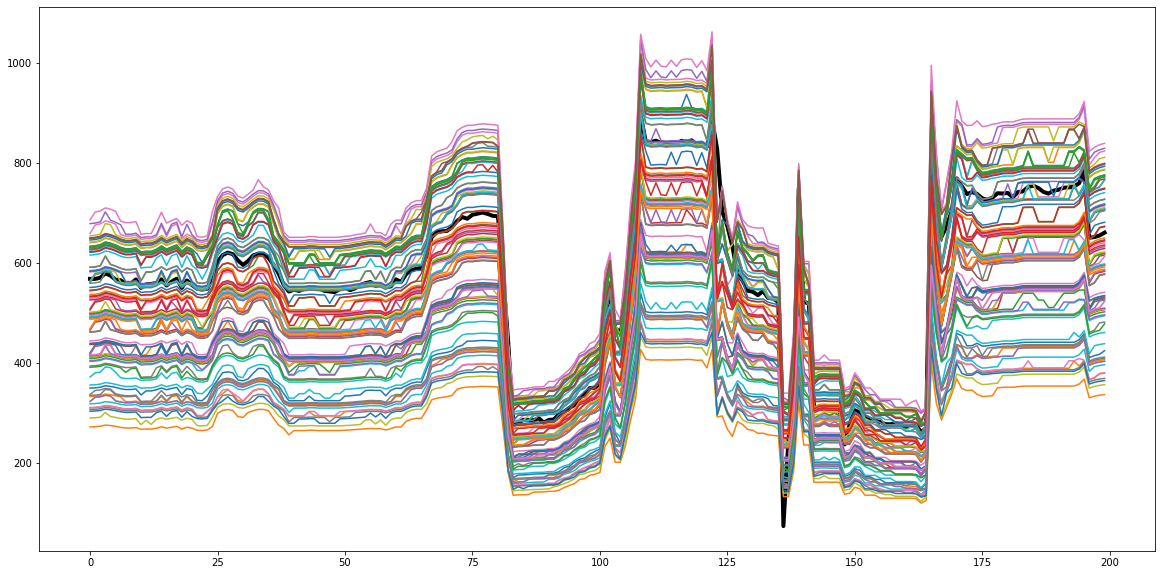

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, figsize = (20, 10))
axs.plot(calibration_data['NB2_S_x_NYZ_x_x_Fcw_x'].values,
         color = 'k', linewidth = 4, label = 'True')
mapes = []
cvrmses = []
for i in range(len(results_clean)):
    result_this = results_clean[i]
    axs.plot(result_this, label = 'run_{}'.format(i))
    mape_i = 100*(abs(calibration_data['NB2_S_x_NYZ_x_x_Fcw_x'].values 
                 - np.array(result_this))/\
                 calibration_data['NB2_S_x_NYZ_x_x_Fcw_x'].values).mean()
    mapes.append(mape_i)
    cvrmse_i = (((calibration_data['NB2_S_x_NYZ_x_x_Fcw_x'].values 
                 - np.array(result_this))**2).sum()/len(result_this))**0.5/\
                calibration_data['NB2_S_x_NYZ_x_x_Fcw_x'].values.mean()
    cvrmses.append(cvrmse_i)
    

In [7]:
def get_t(mo_path):
    chr_pipe_len = None
    chr_v_nom = None
    with open(mo_path) as file:
        lines = file.readlines()
        for line in lines:
            if 'parameter Real chiller_pipe_len=' in line:
                chr_pipe_len = float(line
                                     .split('parameter Real chiller_pipe_len=')[-1]
                                     .split('"m";')[0]
                                     .strip())
            if 'parameter Real chiller_v_nominal=' in line:
                chr_v_nom = float(line
                                     .split('parameter Real chiller_v_nominal=')[-1]
                                     .split('"m/s";')[0]
                                     .strip())
            if chr_pipe_len is not None and chr_v_nom is not None:
                break
    return chr_pipe_len, chr_v_nom
            

In [9]:
# prepare data files for calibration
for i in tgt_dirs:
    res_dir = '{}_{}'.format(base_res_dir, i)
    contents = os.listdir(res_dir)
    result_name = 'chw_sup_m.m_flow'
    calibration_x_names = ['NB2_S_1_NYZ_sys_x_PcwOut_x','NB2_S_1_NYZ_sys_x_PcwIn_x',
                 'NB2_S_1_NYZ_cwp_9_HzSPR_x','NB2_S_1_NYZ_cwp_10_HzSPR_x',
                 'NB2_S_1_NYZ_cwp_11_HzSPR_x','NB2_S_1_NYZ_cwp_12_HzSPR_x']
    calibration_x = calibration_data[calibration_x_names].values
    outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
    result_idx = outputs.index(result_name)
    for content in contents:
        if 'run' in content:
            result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
            result_pd = pd.read_csv(result_file_path, header = None)
            sim_y = result_pd.values[:, result_idx].reshape(-1, 1)
            cali_sim_data = np.concatenate((sim_y, calibration_x), axis = 1)
            mo_file_path = res_dir + os.sep + content\
                        + os.sep + 'compilation'\
                        + os.sep + 'nb_hydr_static_v5.mo'
            chr_pipe_len, chr_v_nom = get_t(mo_file_path)
            sim_t = np.ones((sim_y.shape[0], 2)) * (chr_pipe_len, chr_v_nom)
            cali_sim_data = np.concatenate((cali_sim_data, sim_t), axis = 1)
            cali_sim_data = pd.DataFrame(cali_sim_data)
            column_names = ['m_flow_pred']
            column_names.extend(calibration_x_names)
            column_names.extend(['chiller_pipe_len', 'chiller_v_nominal'])
            cali_sim_data.columns = column_names
            cali_sim_data.to_csv(res_dir + os.sep + content + os.sep + 'cali_sim_data.csv', index=False)

In [10]:
# get all parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []
for i in tgt_dirs:
    res_dir = '{}_{}'.format(base_res_dir, i)
    contents = os.listdir(res_dir)
    for content in contents:
        if 'run' in content:
            data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
            data_i = pd.read_csv(data_file_path)
            parameters.append(data_i.values[0, -2: ])            
parameters = np.array(parameters)
print(parameters[val_idx])

[[109.71035402   0.62268172]
 [ 60.00428144   0.74262847]
 [ 27.16920594   1.63611776]
 [ 82.59670023   1.21378613]
 [ 94.29598422   1.09761867]
 [ 47.89207366   1.37514   ]
 [ 38.33859941   1.25201771]
 [ 44.38280886   0.76625724]
 [ 44.95713977   1.97445004]
 [ 60.05397275   0.91886739]
 [104.444124     1.76219563]
 [141.70369413   1.62335889]
 [145.71700614   1.0063608 ]
 [ 84.47797382   0.93779183]
 [ 67.58188866   0.97762273]
 [ 72.07461303   1.29719554]
 [130.45434712   1.21169721]
 [ 97.56367212   1.41210404]
 [142.25404195   0.74632152]
 [ 89.18443229   1.5848563 ]
 [101.47454724   0.71182566]
 [ 50.74022959   1.53931539]
 [ 42.10951936   1.59304178]
 [ 93.39415227   1.49399174]
 [ 40.88374352   1.68268191]
 [ 36.89449886   1.03203731]
 [ 42.35777637   0.6676457 ]
 [ 48.95543871   1.18374748]
 [ 63.35534157   0.7184804 ]
 [146.01540158   1.65939481]
 [ 76.40046755   0.93826083]
 [ 88.53719605   1.45197371]
 [ 50.57286648   0.85957126]
 [ 26.94733297   1.84681066]
 [ 43.97839609

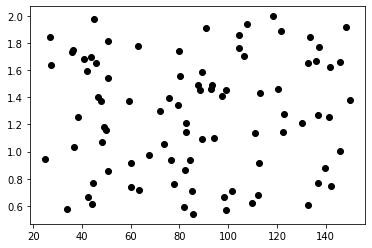

In [11]:
plt.scatter(parameters[:, 0], parameters[:, 1], color ='k')

In [12]:
# get a closer range for the parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []
run_dirs = []
mape_thres = 100
y_true = calibration_data['NB2_S_x_NYZ_x_x_Fcw_x'].values

for i in tgt_dirs:
    res_dir = '{}_{}'.format(base_res_dir, i)
    contents = os.listdir(res_dir)
    for content in contents:
        if 'run' in content:
            data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
            data_i = pd.read_csv(data_file_path)
            y_pred_i = data_i['m_flow_pred'].values
            mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
            if mape_i <= mape_thres:
                parameters.append(data_i.values[0, -2: ])
                run_dirs.append(res_dir + os.sep + content)
            
parameters = np.array(parameters)
print(len(run_dirs))

88


In [13]:
# collect all cali_sim_data
cali_sim_data_all = None
for i in tgt_dirs:
    res_dir = '{}_{}'.format(base_res_dir, i)
    contents = os.listdir(res_dir)
    for content in contents:
        if 'run' in content:
            data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
            if (res_dir + os.sep + content) in run_dirs:
                data_i = pd.read_csv(data_file_path)
                if cali_sim_data_all is None:
                    cali_sim_data_all = data_i
                else:
                    cali_sim_data_all = pd.concat([cali_sim_data_all, data_i],
                                          ignore_index = True)

In [14]:
cali_sim_data_all.shape

(17600, 9)

In [17]:
cali_sim_data_all.to_csv('{}/cali_sim_data_all.csv'.format(cali_dir),
                        index=False)

In [18]:
# Down sample
from BayesianCalibration.DownSampler import DownSampler
import pandas as pd
field_data_columns = ['NB2_S_x_NYZ_x_x_Fcw_x', 'NB2_S_1_NYZ_sys_x_PcwOut_x', 
                      'NB2_S_1_NYZ_sys_x_PcwIn_x', 'NB2_S_1_NYZ_cwp_9_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_10_HzSPR_x', 'NB2_S_1_NYZ_cwp_11_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_12_HzSPR_x']

cali_sim_data_path = './{}/cali_sim_data_all.csv'.format(cali_dir)
field_df = calibration_data[field_data_columns]
field_df.to_csv('./{}/cali_field_data_all.csv'.format(cali_dir),index = False)
bins = 30
quality_thres = 0.8
dirichlet_prior = 0.5
sim_df = pd.read_csv(cali_sim_data_path)
d_sim = sim_df.values
d_field = field_df.values

ds_d_sim = DownSampler(d_sim, bins = bins, dirichlet_prior = dirichlet_prior)
(d_sim_down, d_sim_sp_hist) = ds_d_sim.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres)
d_sim_down_df = pd.DataFrame(d_sim_down)
d_sim_down_df.columns = [list(sim_df.columns)]
d_sim_down_df.to_csv('./{}/cali_sim_data_down.csv'.format(cali_dir), index = False)

[0.00791939 0.01989781 0.03108146 0.03227363 0.04686347 0.05560602
 0.06292932 0.04271927 0.04464945 0.06588135 0.06031791 0.05106443
 0.05333523 0.07434005 0.03783707 0.06514334 0.06474596 0.03636106
 0.02324723 0.02716435 0.02313369 0.02284984 0.01989781 0.00587567
 0.01081465 0.00400227 0.00621629 0.00252626 0.00082316 0.00048254]
52
54
56
58
60
63
66
69
72
75
78
81
85
89
93
97
101
106
111
116
121
127
133
139
145
152
159
166
174
182
191
200
